In [129]:
import math

import random

import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

In [130]:
def read_csv(path, train_test_ratio=0.8):
    
    with open(path) as f:
        lines = f.readlines()[1:]
        
    random.shuffle(lines)
    
    x, y = [], []    
        
    for line in lines:                        
        if 'NA' in line:
            continue
        
        line = line.split(',')
        
        features = line[:4]
        features[1] = float(features[1])
        features[2] = float(features[2])
        features[3] = float(features[3])                
        
        line[4] = 1 if line[4].strip() == '"TRUE"' else 0
        
        x.append(features)
        y.append(line[4])
    
    train_set_size = int(len(x) * train_test_ratio)           
    
    train_x = x[:train_set_size]
    train_y = y[:train_set_size]
    test_x = x[train_set_size:]
    test_y = y[train_set_size:]        
    
        
    return train_x, train_y, test_x, test_y

In [131]:
train_x, train_y, test_x, test_y = read_csv('dataset/seattleWeather_1948-2017.csv')

In [132]:
len(train_x), len(test_x)

(20438, 5110)

In [133]:
# inspect data for normalization

mins = [float('inf')] * 3
maxs = [float('-inf')] * 3

for line in train_x:    
    for i, value in enumerate(line[1:]):
        mins[i] = min(mins[i], value)
        maxs[i] = max(maxs[i], value)

        
mins, maxs

([0.0, 4.0, 0.0], [3.77, 103.0, 71.0])

In [134]:
# helpers

def flatten(array):
    flat = []

    for item in array:
        try:
            iter(item)
            flat.extend(flatten(item))
        except:
            flat.append(item)

    return flat


def reshape(array, rows, cols):
    flat_array = flatten(array)

    if rows * cols != len(flat_array):
        raise Exception(f"Can't reshape array to ({rows}, {cols})")

    reshaped = [[0] * cols for _ in range(rows)]    

    for row in range(rows):
        for col in range(cols):
            reshaped[row][col] = flat_array[row * cols + col]

    return reshaped

def argmax(values):
    max_value = float('-inf')
    max_index = 0

    for idx, value in enumerate(values):
        if value > max_value:
            max_index = idx
            max_value = value

    return max_index


def prepare(x):
    x = x[1:]
    
    for i in range(1, len(x)):
        x[i] = (x[i] - mins[i - 1]) / (maxs[i - 1] - mins[i - 1])
    
    return x

In [135]:
train_x_normalized = []

for x in train_x:
    train_x_normalized.append(prepare(x))

### Logistic Regression

In [136]:
def sigmoid_scalar(x):
    # to avoid overflow
    if x < 0:
        sigmoid = math.exp(x) / (1 + math.exp(x))
    else:
        sigmoid = 1 / (1 + math.exp(-x))

    # to handle machine precision errors
    sigmoid = max(0.0001, sigmoid)
    sigmoid = min(0.9999, sigmoid)

    return sigmoid

In [137]:
def predict(sample_x, weights):
    # calculate z = sum(w * x + b)
    # here bias (b) is also included in weights
    z = 0
    for x, w in zip(sample_x, weights):
        z += w * x

    # sigmoid(z)
    return sigmoid_scalar(z)

In [138]:
def cross_entropy_loss(predicted_value, actual_value):
    y = actual_value
    y_pred = predicted_value    

    if y == 1:        
        return -math.log(y_pred)

    else:        
        return -math.log(1 - y_pred)

In [139]:
def gradient_decent(X, label, weights=None, learning_rate=0.1):
    n_features = len(X[0])

    # initialize weight with random values (equal length to x's features)
    if weights == None:
        weights = [random.random() for _ in range(n_features)]

    loss = 0

    for x, y in zip(X, label):
        y_pred = predict(x, weights)
        loss += cross_entropy_loss(y_pred, y)

        # dw = (y_pred - y) * x
        # weight = weight - learning_rate * dw
        err = y_pred - y
        for i in range(n_features):
            dw_i = err * x[i]
            weights[i] -= learning_rate * dw_i

    return weights, loss / len(X)

In [140]:
def train_binary_class(x_train, y_train, learning_rate, epoch, verbose=False):
    weights = None

    # for graphing
    history = []

    for i in range(epoch):
        weights, loss = gradient_decent(x_train, y_train, weights, learning_rate)

        history.append(loss)

        if verbose:
            print(f"Epoch [{i}]\n\t- Cross entropy loss: {loss}")

    return weights, history

In [141]:
def predict_class(sample_x, model):
    if predict(sample_x, model) > 0.5:
        return 1
    return 0
    

In [142]:
def test(x_test, y_test, model):        
    net_accuracy = 0

    for i in range(len(x_test)):
        
        prediction = predict_class(x_test[i], model)
        
        if prediction == y_test[i]:
            net_accuracy += 1

    return net_accuracy / len(x_test)

In [143]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]

epochs = 100

histories = []

for eta in learning_rates:
    print(f'\nLearning rate: {eta}')
    
    model, history = train_binary_class(train_x_normalized, train_y, eta, epochs, verbose=True)
    
    histories.append((model, history))
            


Learning rate: 0.0001
Epoch [0]
	- Cross entropy loss: 0.665682293559504
Epoch [1]
	- Cross entropy loss: 0.6410973161836179
Epoch [2]
	- Cross entropy loss: 0.6340756741134215
Epoch [3]
	- Cross entropy loss: 0.6274492010567391
Epoch [4]
	- Cross entropy loss: 0.621187960684652
Epoch [5]
	- Cross entropy loss: 0.6152629274670424
Epoch [6]
	- Cross entropy loss: 0.6096468327510742
Epoch [7]
	- Cross entropy loss: 0.6043145501822094
Epoch [8]
	- Cross entropy loss: 0.5992431863024876
Epoch [9]
	- Cross entropy loss: 0.5944120076457351
Epoch [10]
	- Cross entropy loss: 0.5898022896600225
Epoch [11]
	- Cross entropy loss: 0.5853971366199126
Epoch [12]
	- Cross entropy loss: 0.5811812984067921
Epoch [13]
	- Cross entropy loss: 0.5771409965896138
Epoch [14]
	- Cross entropy loss: 0.5732637649962061
Epoch [15]
	- Cross entropy loss: 0.5695383062670467
Epoch [16]
	- Cross entropy loss: 0.5659543640969544
Epoch [17]
	- Cross entropy loss: 0.5625026100752755
Epoch [18]
	- Cross entropy loss: 0

Epoch [56]
	- Cross entropy loss: 0.3171231918982622
Epoch [57]
	- Cross entropy loss: 0.3159356764662085
Epoch [58]
	- Cross entropy loss: 0.3147717984828123
Epoch [59]
	- Cross entropy loss: 0.3136307246303448
Epoch [60]
	- Cross entropy loss: 0.3125116667733273
Epoch [61]
	- Cross entropy loss: 0.31141387202714255
Epoch [62]
	- Cross entropy loss: 0.31033662613561686
Epoch [63]
	- Cross entropy loss: 0.30927924829198183
Epoch [64]
	- Cross entropy loss: 0.3082410900112015
Epoch [65]
	- Cross entropy loss: 0.30722153664775015
Epoch [66]
	- Cross entropy loss: 0.3062199985997156
Epoch [67]
	- Cross entropy loss: 0.30523591479101436
Epoch [68]
	- Cross entropy loss: 0.304268746789755
Epoch [69]
	- Cross entropy loss: 0.3033179801482197
Epoch [70]
	- Cross entropy loss: 0.30238312407727785
Epoch [71]
	- Cross entropy loss: 0.3014637096850109
Epoch [72]
	- Cross entropy loss: 0.3005592864312525
Epoch [73]
	- Cross entropy loss: 0.2996694214705682
Epoch [74]
	- Cross entropy loss: 0.29879

Epoch [9]
	- Cross entropy loss: 1.115148063044526
Epoch [10]
	- Cross entropy loss: 1.0848228995577562
Epoch [11]
	- Cross entropy loss: 1.059191449531397
Epoch [12]
	- Cross entropy loss: 1.0208444661665823
Epoch [13]
	- Cross entropy loss: 1.0252648334310996
Epoch [14]
	- Cross entropy loss: 0.9959229117262591
Epoch [15]
	- Cross entropy loss: 0.9830795002232107
Epoch [16]
	- Cross entropy loss: 0.9737012959162991
Epoch [17]
	- Cross entropy loss: 0.9518929598644057
Epoch [18]
	- Cross entropy loss: 0.9366241570219662
Epoch [19]
	- Cross entropy loss: 0.9275098497597385
Epoch [20]
	- Cross entropy loss: 0.9032030361571174
Epoch [21]
	- Cross entropy loss: 0.9044458173111151
Epoch [22]
	- Cross entropy loss: 0.9038547547674762
Epoch [23]
	- Cross entropy loss: 0.888032190774053
Epoch [24]
	- Cross entropy loss: 0.8832910831620138
Epoch [25]
	- Cross entropy loss: 0.8733537958292008
Epoch [26]
	- Cross entropy loss: 0.8586026586804872
Epoch [27]
	- Cross entropy loss: 0.85081399394490

Epoch [65]
	- Cross entropy loss: 0.9874135371287224
Epoch [66]
	- Cross entropy loss: 0.9755436707492318
Epoch [67]
	- Cross entropy loss: 0.9759815405470527
Epoch [68]
	- Cross entropy loss: 0.9784324596252104
Epoch [69]
	- Cross entropy loss: 1.0011103009349747
Epoch [70]
	- Cross entropy loss: 0.993165513358889
Epoch [71]
	- Cross entropy loss: 0.9758784082052517
Epoch [72]
	- Cross entropy loss: 0.9276117259025458
Epoch [73]
	- Cross entropy loss: 0.9558803856354685
Epoch [74]
	- Cross entropy loss: 0.9513689536219141
Epoch [75]
	- Cross entropy loss: 0.9270528774290803
Epoch [76]
	- Cross entropy loss: 0.9551118885607692
Epoch [77]
	- Cross entropy loss: 0.9305610695008462
Epoch [78]
	- Cross entropy loss: 0.9264816731097382
Epoch [79]
	- Cross entropy loss: 0.9381897166086866
Epoch [80]
	- Cross entropy loss: 0.9345099772113576
Epoch [81]
	- Cross entropy loss: 0.9338436367471056
Epoch [82]
	- Cross entropy loss: 0.9210966917595377
Epoch [83]
	- Cross entropy loss: 0.93609951444

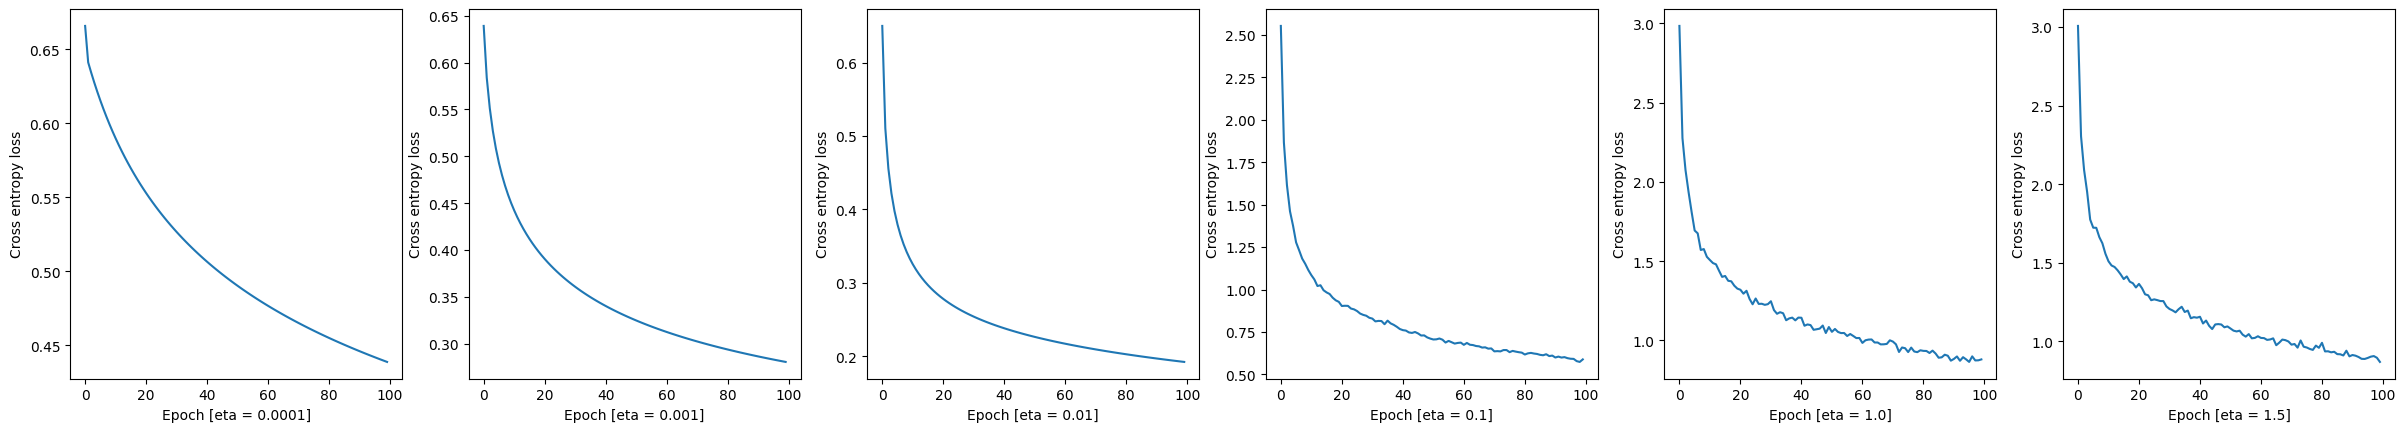

In [144]:
# draw training history for each learing rates

fig, axs = plt.subplots(nrows=1, ncols=len(learning_rates))
fig.set_figwidth(30)
    
for i, ax in enumerate(axs.flat):
    
    ax.set_xlabel(f'Epoch [eta = {learning_rates[i]}]')
    ax.set_ylabel(f'Cross entropy loss')

    ax.plot(range(100), histories[i][1])

In [145]:
test_x_normalized = list(map(prepare, test_x))

for i, eta in enumerate(learning_rates):    
    acc = test(test_x_normalized, test_y, histories[i][0])
    print(f'Learning rate: {eta} \tAccuracy: {acc}')

Learning rate: 0.0001 	Accuracy: 0.7935420743639922
Learning rate: 0.001 	Accuracy: 0.8802348336594912
Learning rate: 0.01 	Accuracy: 0.9358121330724071
Learning rate: 0.1 	Accuracy: 0.9489236790606653
Learning rate: 1.0 	Accuracy: 0.9583170254403132
Learning rate: 1.5 	Accuracy: 0.9299412915851272
